# Ultimate Technologies Inc. Take-Home Challenge


In [23]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from datetime import datetime, timedelta

# Part 1 ‐ Exploratory data analysis

The logins.json file contains simulated timestamps of user logins in a specific geographic location. 

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


**Aggregate login counts based on 15minute time intervals**

In [5]:
# Resample the data to 15-minute bins using resample() function
# Sum the values of the timestamps falling into a bin.

logins.set_index('login_time', inplace=True)
logins['login_counts'] = 1

logins_resampled = logins.resample('15T').sum()

In [7]:
logins_resampled.head()

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


**Visualize time series of login counts**

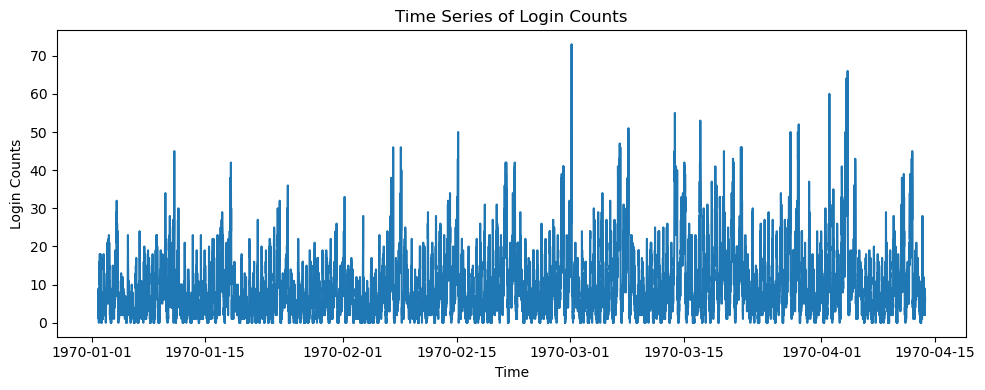

In [12]:
# plot time series of login counts
plt.figure(figsize=(10, 4))
plt.plot(logins_resampled.index, logins_resampled['login_counts'])
plt.title('Time Series of Login Counts')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.tight_layout()
plt.show()

- It seems there is an overall increasing trend in the login counts 
- There is a clear daily pattern in the data, with consistent peaks and troughs indicating higher and lower user login activity at certain times of the day.

**Login Counts by Hour of the Day**

To investigate the daily cycles, aggregate the data by the hour of the day and visualize the average login counts for each hour.

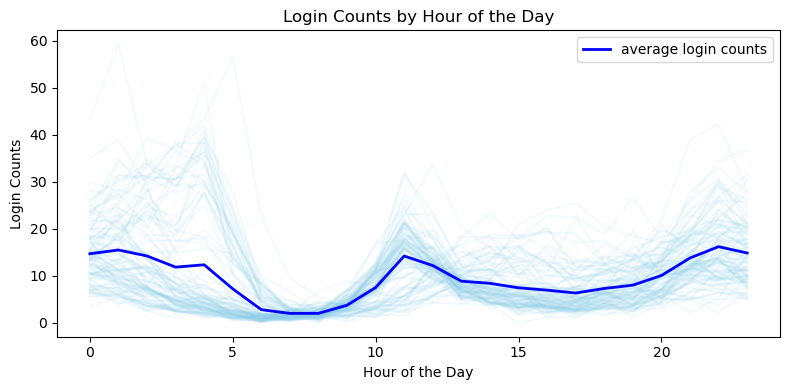

In [13]:
# Extract the date and hour from the index
logins_resampled['date'] = logins_resampled.index.date
logins_resampled['hour'] = logins_resampled.index.hour

# Plot the average login pattern for each day
fig, ax = plt.subplots(figsize=[8,4])

for _, daily_data in logins_resampled.groupby('date'):
    hourly_data = daily_data.groupby('hour')['login_counts'].mean().reset_index()
    ax.plot(hourly_data['hour'], hourly_data['login_counts'], color='skyblue', alpha=0.1)

mean_hourly_data = logins_resampled.groupby('hour')['login_counts'].mean().reset_index()
ax.plot(mean_hourly_data['hour'], mean_hourly_data['login_counts'], color='blue', linewidth=2, label='average login counts')


ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Login Counts')
ax.set_title('Login Counts by Hour of the Day')
ax.legend()

plt.tight_layout()
plt.show()


- The plot displays the average number of logins on the Y-axis for each hour of the day on the X-axis, ranging from 0 to 23. The transparent lines indicate the average login count for each day, while the bold line represents the overall average login count across all the days in the dataset.

- The login counts show a dip in the morning hours (6-9 AM), gradually increasing towards the afternoon and peaking at 1-2 PM. The most significant peak occurs in the evening to night time, particularly from 9 PM to 2 AM, suggesting that a large number of users are most active during this period. Following the peak, there is a dip in the late night to early morning hours (3-6 AM).


**Login Counts by Day of Week**

In [14]:
logins_resampled['week'] = (logins_resampled.index - logins_resampled.index[0]).days // 7
logins_resampled['day_of_week'] = logins_resampled.index.dayofweek
logins_resampled['time_of_day'] = logins_resampled.index.time
logins_resampled['time_of_week'] = logins_resampled['day_of_week'] * 1440 + logins_resampled.index.hour * 60 + logins_resampled.index.minute

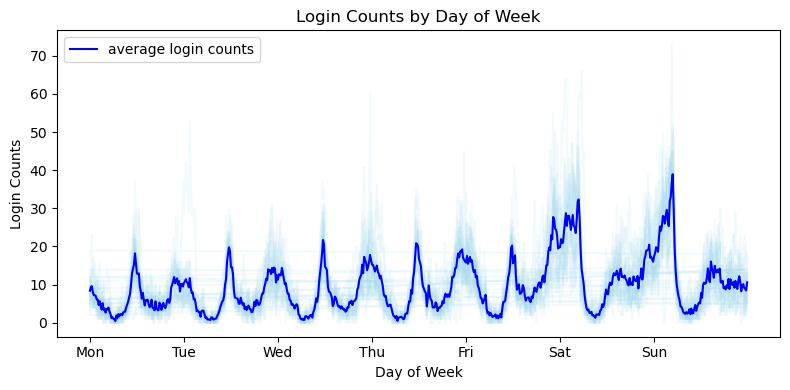

In [16]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, ax = plt.subplots(figsize=[8, 4])

# Plot weekly patterns
for _, ts in logins_resampled.groupby('week'):
    ax.plot(ts['time_of_week'], ts['login_counts'],color='skyblue', alpha=0.1)

# Plot mean pattern
mean_pattern = logins_resampled.groupby('time_of_week')['login_counts'].mean()
ax.plot(mean_pattern.index, mean_pattern, color='blue', label='average login counts')

plt.xticks(ticks=np.arange(0, 1440*7, 1440), labels=DAYS)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Login Counts')
ax.set_title('Login Counts by Day of Week')

ax.legend()
plt.tight_layout()
plt.show()


- The login counts gradually increases throughout the week, peaking on Saturday and Sunday before dropping on Monday.

**Data quality issues**

In [21]:
logins.index.min()

Timestamp('1970-01-01 20:12:16')

In [22]:
logins.index.max()

Timestamp('1970-04-13 18:57:38')

The timestamp in the logins.json file begins from the year 1970, which appears suspicious. It seems to be a placeholder or dummy year used in the dataset. This can have an impact on the analysis of weekly patterns.

# Part 2 ‐ Experiment and metrics design

**Questions**
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * how you will implement the experiment  
    * what statistical test(s) you will conduct to verify the significance of the observation   
    * how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**Answer**

During weekdays,  two neighboring cities have different peak hours, making it less attractive for drivers to cross the bridge and provide services in both cities. The proposed experiment aims to address this issue by reimbursing all toll costs to driver partners, thus encouraging them to be available in both cities.

The success of the experiment depends on the frequency of toll bridge usage by driver partners during weekdays. In other words, if the experiment proves successful, a significant rise in the number of drivers willing to cross the toll bridge would indicate that reimbursing toll costs has effectively incentivized them to serve both cities.

In order to evaluate the effectiveness of the toll reimbursement program, it is essential to gather baseline data before its implementation. This data should focus on the number of drivers who cross the toll bridge, serving both Gotham and Metropolis during weekdays. This will give us a point of reference to compare with post-implementation results. Once the baseline data has been collected, the experiment can be launched. Following the implementation, data should be collected again to assess the effectiveness of the program.

To verify the significance of the observation, perform a statistical test to compare the baseline data with the data gathered after the implementation of the toll reimbursement program. A two-sample t-test could be appropriate for this comparison. A two-sample t-test might be the most appropriate method for this comparison. The null hypothesis (H0) states that there is no significant difference in the number of drivers serving both cities before and after the toll reimbursement program. On the other hand, the alternative hypothesis (H1) asserts that there is a significant increase in the number of drivers serving both cities after the implementation of the program. If the statistical test yields a p-value less than the chosen significance level, it indicates a significant increase in the number of drivers serving both cities after the toll reimbursement program.

# Part 3 ‐ Predictive modeling

To predict rider retention, analyze a dataset of users who signed up in Jan 2014. The dataset was collected several months after sign-up,  a user is considered retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
# Convert columns to datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

## Retained Users

In [5]:
most_recent = df['last_trip_date'].max()
print(f"The most recent date in the dataset is {most_recent.strftime('%Y-%m-%d')}")


The most recent date in the dataset is 2014-07-01


To clarify, a user is considered “retained” if they took a trip between June 2, 2014 and July 1, 2014. This is because the most recent date in the dataset is July 1, 2014, and the 30-day window for determining retention ends on that date.

In [6]:
# Create a column indicating if user had trip in last 30 days. 0 for retained, 1 otherwise.
df['retained'] = (df['last_trip_date'] >= (most_recent - timedelta(days=30))).astype(int)

In [7]:
fraction = df['retained'].mean()
print(f"Approximately {fraction*100:.2f}% of the observed users are retained")

Approximately 37.61% of the observed users are retained


## Missing Values

In [8]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

The dataset contains missing values in the following columns:
`avg_rating_of_driver`, `phone`, `avg_rating_by_driver`

In [9]:
df['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [10]:
# Fill missing values in the 'phone' column with 'Unknown'
df['phone'].fillna('Unknown', inplace=True)

In [11]:
df['avg_rating_of_driver'].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

In [12]:
df['avg_rating_by_driver'].unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
       3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
       1.5, 2.7])

In [13]:
# Fill missing values in 'avg_rating_of_driver' and 'avg_rating_by_driver' columns with mean
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int64 

## EDA

In [15]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [22]:
# Calculate the mean of each numerical column grouped by the 'retained' status
numerical_avg = df.groupby('retained')[numerical_columns].mean()

numerical_avg.drop(columns='retained')

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
retained,,,,,,,
0,1.658482,4.606309,1.075339,8.666739,60.647032,6.207939,4.787415
1,3.306318,4.593679,1.073809,9.152797,61.389034,5.114788,4.762801


- Retained users tend to take more trips in their first 30 days, with an average of approximately 3.31 trips, while non-retained users have an average of approximately 1.66 trips. 

- The average surge percentage is slightly higher for retained users (approximately 9.15%) compared to non-retained users (approximately 8.67%). 

- Non-retained users, on average, travel a slightly longer distance per trip, with approximately 6.21 miles, compared to retained users, who travel approximately 5.11 miles per trip.


- The differences in the remaining columns are relatively insignificant. 

In [23]:
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()

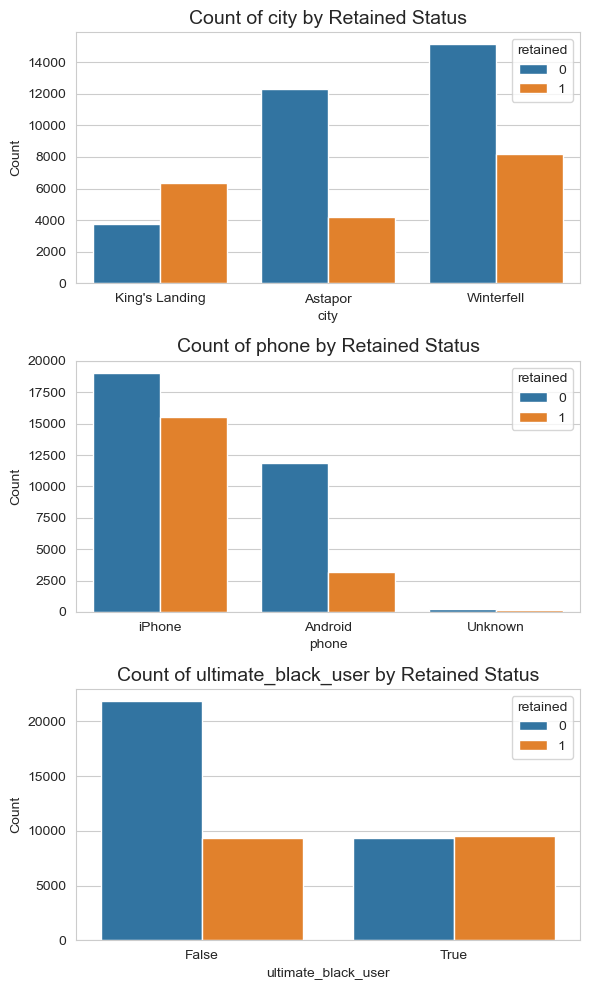

In [32]:
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(6, 10))

# create bar plots
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, hue='retained', data=df, ax=axes[i])
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Count of {col} by Retained Status', fontsize=14)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()



**City**: 
In King's Landing, a higher proportion of users are retained compared to the other cities. Astapor has the highest number of non-retained users, followed by Winterfell.

**Phone**: 
iPhone users have a higher retention rate compared to Android users. The number of non-retained Android users is significantly higher than the number of retained Android users.

**Ultimate Black User**: 
Users who are not Ultimate Black users have a lower retention rate compared to those who are Ultimate Black users. Ultimate Black users have a higher retention rate, with a nearly equal number of retained and non-retained users.

## Categorical Columns

The categorical columns in the data are `city`, `phone`, and `ultimate_black_user`

In [15]:
# one-hot encoding for the city and phone
one_hot_encoded = pd.get_dummies(df[['city', 'phone']],dtype=int)
df = pd.concat([df, one_hot_encoded], axis=1)

In [16]:
# Convert boolean column to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# Build a Predictive Model

## Feature Selection and Train/Test Split

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int64 

In [21]:
# Feature Selection 

features = ['trips_in_first_30_days', 
            'avg_rating_of_driver', 
            'avg_surge',
            'surge_pct', 
            'weekday_pct',
            'avg_dist',
            'avg_rating_by_driver', 
            'city_Astapor',
            "city_King's Landing", 
            'city_Winterfell',
            'phone_Android',
            'phone_Unknown',
            'phone_iPhone'
             ]

target = 'retained'

In [24]:
# Splitting the data into training and testing sets

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## The Logistic Regression Model

In [25]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      6219
           1       0.69      0.43      0.53      3781

    accuracy                           0.71     10000
   macro avg       0.70      0.65      0.66     10000
weighted avg       0.71      0.71      0.69     10000



I chose Logistic Regression as the baseline model due to its simplicity and interpretability, which makes it easy to comprehend how each feature influences the odds of retention, based on the coefficients.  

The dataset seems to be imbalanced, with more non-retained users than retained users. This could lead to the model incorrectly classifying the minority class. While the accuracy rate is around 71%, the model’s precision and recall for the non-retained class are higher, indicating that it’s better at identifying non-retained users than retained ones. However, the F1-Score for the retained class is only 52%, which suggests that the model may struggle to identify retained users accurately.

Alternatively, Decision Trees, Random Forest, Gradient Boosting Machines, and Support Vector Machines could be used to capture more complex patterns in the data.